# 2. Score classic methods

In [13]:
import ast
import pandas as pd

from common import score_models, clean_string, load_preds

In [5]:
reading_lists = pd.read_csv("../reading_lists.csv")
reading_lists['reading_list'] = reading_lists['reading_list'].apply(ast.literal_eval)

trues = { id_:[clean_string(ref["title"]) for ref in references if ref["acl_id"]] for id_, references in zip(reading_lists["id"], reading_lists["reading_list"]) }

In [7]:
models_paths = {
    "Semantic Scholar (Any)": "classic_methods/preds/semantic_scholar/any",
    "Semantic Scholar (Any - Most Cited)": "classic_methods/preds/semantic_scholar/any_most_cited",
    "Semantic Scholar (ACL)": "classic_methods/preds/semantic_scholar/acl",
    "Semantic Scholar (ACL - Most Cited)": "classic_methods/preds/semantic_scholar/acl_most_cited",
    "BM25": "classic_methods/preds/bm25",
    "SPECTER2": "classic_methods/preds/specter2",
}

## Default comparison

In [8]:
table = score_models(trues, models_paths.keys(), models_paths.values(), split_by_years=False, use_title_instead_of_id=True); table 
#print(table.to_latex(float_format="{:0.1f}".format))

recall                       \
                                            A1        A2         A3   
Semantic Scholar (Any)                4.478147  3.816047   6.673190   
Semantic Scholar (Any - Most Cited)   5.587084  4.774951   8.228963   
Semantic Scholar (ACL)                8.649706  6.242661  10.476190   
Semantic Scholar (ACL - Most Cited)  10.613177  5.936073  14.602087   
BM25                                  8.873668  8.489889  11.156773   
SPECTER2                              5.787671  5.676778   8.245864   

                                                    ndcg                      \
                                          Mean        A1        A2        A3   
Semantic Scholar (Any)                4.989128  2.234190  2.423912  3.873268   
Semantic Scholar (Any - Most Cited)   6.196999  3.781928  3.504234  6.307127   
Semantic Scholar (ACL)                8.456186  5.773403  4.730437  7.476942   
Semantic Scholar (ACL - Most Cited)  10.383779  7.285707  4.277447  9.851281   
BM25                                  9.506777  5.722704  5.105861  6.581614   
SPECTER2                              6.570104  3.064759  3.397064  4.709815   

                                                     mrr                       \
                                         Mean         A1        A2         A3   
Semantic Scholar (Any)               2.843790   2.563777  3.529300   5.477253   
Semantic Scholar (Any - Most Cited)  4.531096   6.097498  4.979687  10.484522   
Semantic Scholar (ACL)               5.993594   8.293839  6.950424  11.021418   
Semantic Scholar (ACL - Most Cited)  7.138145  10.958481  6.517227  13.265505   
BM25                                 5.803393   8.765831  5.929288   9.199094   
SPECTER2                             3.723880   3.333865  4.578341   5.763281   

                                                
                                          Mean  
Semantic Scholar (Any)                3.856777  
Semantic Scholar (Any - Most Cited)   7.187236  
Semantic Scholar (ACL)                8.755227  
Semantic Scholar (ACL - Most Cited)  10.247071  
BM25                                  7.964738  
SPECTER2                              4.558496

## Matches of correct prediction

In [9]:
def match(trues:dict, preds1:dict, preds2:dict) -> float:
    match = 0
    size = 0
    for k, trues_v in trues.items():
        if trues_v != []:
            match1 = set(dict.fromkeys(trues_v)) & set(dict.fromkeys(preds1[k]))
            match2 = set(dict.fromkeys(trues_v)) & set(dict.fromkeys(preds2[k]))
            match += len(match1 & match2)
            size += 1
    return match/size

In [10]:
bm25_preds = load_preds("classic_methods/preds/bm25", use_title_instead_of_id=True)
specter2_preds = load_preds("classic_methods/preds/specter2", use_title_instead_of_id=True)

(match(trues, bm25_preds["A1"], specter2_preds["A1"]) +\
match(trues, bm25_preds["A2"], specter2_preds["A2"]) +\
match(trues, bm25_preds["A3"], specter2_preds["A3"])) /3

0.1050228310502283

## Citations differences analysis

In [ ]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

""" Compute and plot an histogram of % of citations"""
def citations_histogram(path:str) -> None:
    preds_citations = []
    for annotator_i in [1,2,3]:
        path_annots = Path(f'{path}/preds_annot{annotator_i}.json')
        annot_citations = { id_:[ref["citationCount"] for ref in references] for id_, references in json.loads(path_annots.read_text()).items()}
        annot_citations = json.loads(json.dumps(annot_citations))
        for _, citations in annot_citations.items():
            preds_citations = preds_citations + citations
    hist, bins = np.histogram(preds_citations, [0, 10, 50, 100, 1000, max(preds_citations)])
    hist = [(count / len(preds_citations)) * 100 for count in hist]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(hist)),hist,width=0.95, align="edge", color='#18dcff') 
    for container in ax.containers:# Add bar labels
        ax.bar_label(container,fmt='%.0f%%', padding=3, fontweight="bold", fontsize="large", color='#18dcff')
    ax.set_xticks([0.5+i for i,j in enumerate(hist)])
    ax.set_xticklabels([f"[{bins[i]}:{bins[i+1]}]" for i,j in enumerate(hist)])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Referenced papers", fontsize="x-large", fontfamily="Helvetica Neue")
    ax.set_ylabel("% of citations", fontsize="x-large", fontfamily="Helvetica Neue")
    ax.tick_params(axis='both', which='major', labelsize="x-large", labelfontfamily="Helvetica Neue", direction="out")
    plt.show()

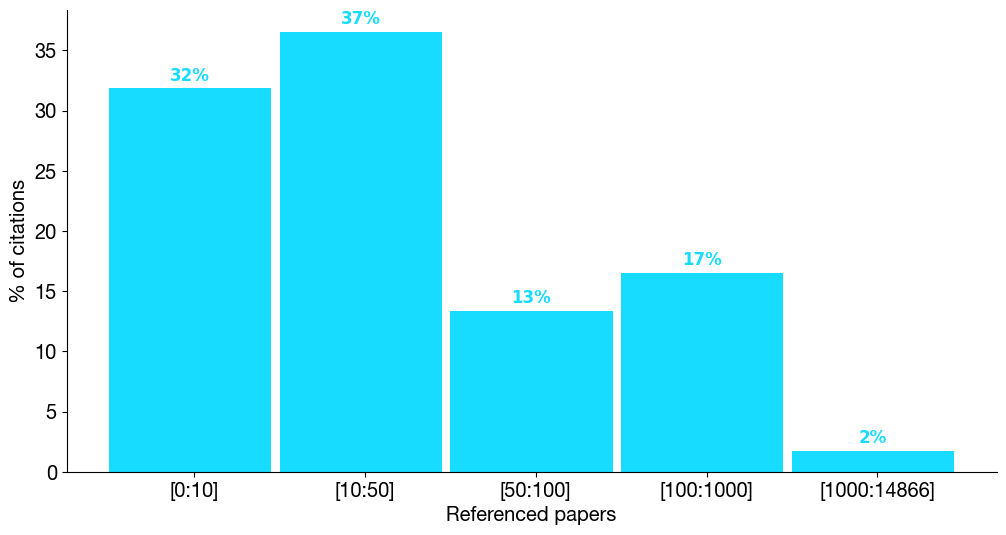

In [22]:
citations_histogram("classic_methods/preds/semantic_scholar/acl")

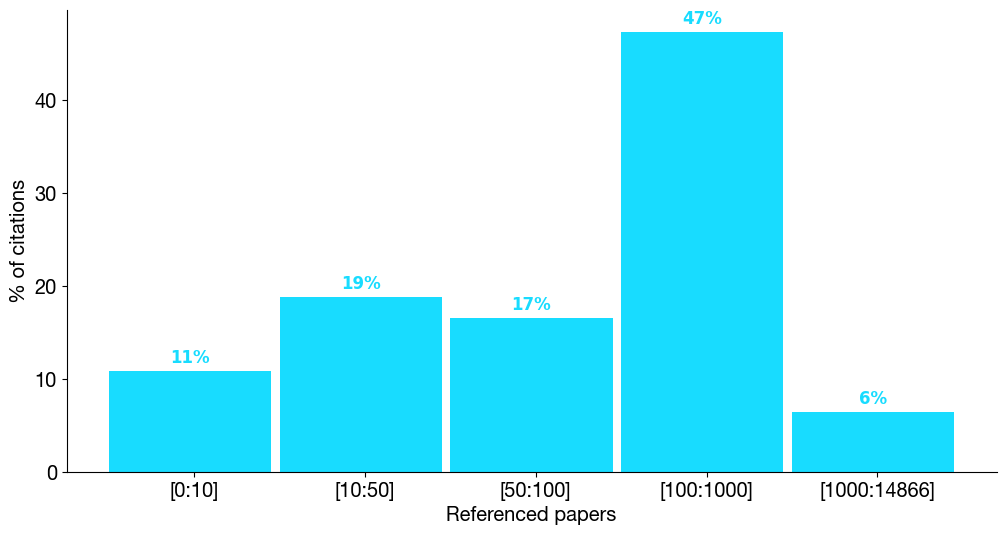

In [23]:
citations_histogram("classic_methods/preds/semantic_scholar/acl_most_cited")